# Evaluate pseudotime goodness-of-fit by scDesign3

In this example, we will show how to use scDesign3 to evaluate the pseudotime goodness-of-fit for different pseudotime labels. If the true labels are unavailable and we have little prior knowledge, the scDesign3 BIC can serve as an unsupervised metric. In this tutorial, we will first use the R package `dyngen` to generate a dataset with ground truth "pseudotime". Then, we will perturb the ground truth pseudotime to worsen its quality and use scDesign3’s BIC to examine pseudotime goodness-of-fit.

## Generation of reference dataset & Simulation

We first generate a synthetic dataset with ground truth pseudotime using `dyngen` package in R. R is called in this jupyter notebook by `rpy2` package.

In [1]:
%load_ext rpy2.ipython

In [2]:
%%R
library(scDesign3)
library(dyngen)
library(SingleCellExperiment)
library(ggplot2)
library(dplyr)
theme_set(theme_bw())

Registered S3 method overwritten by 'scDesign3':
  method         from  
  predict.gamlss gamlss
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, 

In [3]:
%%R
set.seed(123)
backbone <- backbone_linear_simple()
config <-
  initialise_model(
    backbone = backbone,
    num_cells = 500,
    num_tfs = nrow(backbone$module_info),
    num_targets = 100,
    num_hks = 50,
    verbose = FALSE
  )
out <- generate_dataset(
  config,
  format = "sce",
  make_plots = FALSE
  )
example_sce <- out$dataset
colData(example_sce)$pseudotime <- out$model$experiment$cell_info$time 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~00s           |++                                                | 3 % ~00s           |++                                                | 4 % ~00s           |+++                                               | 5 % ~00s           |++++                                              | 6 % ~00s           |++++                                              | 8 % ~00s           |+++++                                             | 9 % ~00s           |++++++                                            | 10% ~00s           |++++++                                            | 12% ~00s           |+++++++                                           | 13% ~00s           |++++++++                                          | 14% ~00s           |++++++++                                          | 15% ~00s           |+++++++++                                         | 17% ~00s 

Then we convert the SingleCellExperiment object to an AnnData object in Python.


In [4]:
%%R
library(zellkonverter)
writeH5AD(example_sce, "data/pseudotime_example_sce.h5ad")


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    ℹ Using the 'counts' assay as the X matrix


Registered S3 method overwritten by 'zellkonverter':
  method                                             from      
  py_to_r.pandas.core.arrays.categorical.Categorical reticulate


In [5]:
import anndata as ad
example_sce = ad.read_h5ad("data/pseudotime_example_sce.h5ad")
example_sce.X

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 68069 stored elements and shape (500, 155)>

Secondly, we perturb the pseudotime by generating random numbers from uniform distribution and replacing various percentages of the original pseudotime with random numbers. The percentage ranges from 0% to 100%. In the code below, we generate 11 sets of perturbed pseudotime with the percentage of perturbation ranging from 0% to 100%. For each new set of perturbed pseudotime, we create a new SingleCellExperiment object, storing the original count matrix and the corresponding perturbed pseudotime.

In [6]:
example_sce.obs.head()

,step_ix,simulation_i,sim_time,pseudotime
cell1,106,3,16.008333,0.263991
cell2,1169,27,44.008333,0.702819
cell3,1305,30,60.008333,0.988890
cell4,762,18,0.000000,0.027913
cell5,19,1,20.008333,0.383419


In [7]:
import numpy as np
import copy

np.random.seed(123)

original_pseudotime = example_sce.obs["pseudotime"].values

pertubed_sce_list = []

for x in range(10):
    perturb_prop = x/10
    n_cell = int(round(example_sce.n_obs * perturb_prop))
    
    cell_index = np.random.choice(example_sce.n_obs, size=n_cell, replace=False)
    
    new_pseudotime = original_pseudotime.copy()
    new_pseudotime[cell_index] = np.random.uniform(0, 1, n_cell)
    
    new_sce = example_sce.copy()
    new_sce.obs["pseudotime"] = new_pseudotime
    
    pertubed_sce_list.append(new_sce)

Thirdly, we iteratively use scDesign3 to estimate the pseudotime-based simulator.

Original R code:
```{r}
set.seed(123)
scDesign3_result <- lapply(example_sce_list, function(x) {
  res <-  scdesign3(
    sce = x,
    assay_use = "counts",
    celltype = NULL,
    pseudotime = "pseudotime",
    spatial = NULL,
    other_covariates = NULL,
    mu_formula = "s(pseudotime, bs = 'cr', k = 10)",
    sigma_formula = "1",
    corr_formula = "ind",
    copula = "gaussian",
    n_cores = 2
  )
  return(res)
})
```

In [8]:
from scdesigner.simulators import NegBinRegressionSimulator
import scipy

scdesign_result = []
for sce in pertubed_sce_list:
    if scipy.sparse.issparse(sce.X):
        sce.X = sce.X.toarray()
    sim = NegBinRegressionSimulator(batch_size=500)
    sim.fit(sce, "~ bs(pseudotime, degree=9)")
    scdesign_result.append(sim.marginal_bic) #.item()

scdesign_result

[606164.5625,
 611458.0,
 614329.0625,
 617092.5625,
 617215.3125,
 619269.0625,
 621128.3125,
 623667.0625,
 622908.3125,
 625887.1875]

In [9]:
from scipy.stats import pearsonr

# Assuming example_sce_list[0] and x are AnnData objects
pseudo1 = original_pseudotime
pseudo_list = [x.obs['pseudotime'].values for x in pertubed_sce_list]

r_squared = [pearsonr(pseudo1, pseudo2)[0]**2 for pseudo2 in pseudo_list]
r_squared

[np.float64(1.0),
 np.float64(0.8255787178672839),
 np.float64(0.6894546242094367),
 np.float64(0.48584447381233686),
 np.float64(0.39854349451272686),
 np.float64(0.3630690563344239),
 np.float64(0.2108723345139278),
 np.float64(0.11636269119725595),
 np.float64(0.06822691443447866),
 np.float64(0.022576431064499736)]

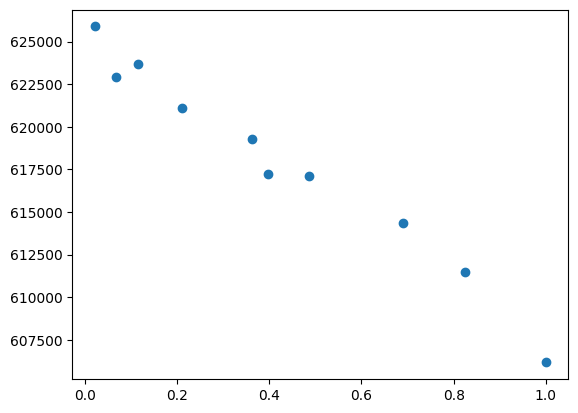

In [10]:
import matplotlib.pyplot as plt

plt.scatter(r_squared, scdesign_result)

We can see that the marginal BIC value agrees with the r-squared value.